In [1]:
# The code was removed by Watson Studio for sharing.

# **Space X  Falcon 9 First Stage Landing Prediction**


## Assignment:  Machine Learning Prediction


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing\_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


## Import Libraries and Define Auxiliary Functions


We will import the following libraries for the lab


In [2]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier
# Import metrics from sklearn
from sklearn import metrics
# Import cross_val_score to compare models
from sklearn.model_selection import KFold, cross_val_score
#import sys
import sys
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=sys.maxsize)

This function is to plot the confusion matrix.


In [3]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'landed']); ax.yaxis.set_ticklabels(['did not land', 'landed'])

## Load the dataframe


Load the data


In [4]:
data = pd.read_csv(project.get_file('pre_data_feature.csv'))

print(data.shape)
data.head()

(132, 21)


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,PayloadName,Customer,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,Serial,ReusedCount,LaunchSite,Longitude,Latitude,Block_Version,Class
0,1,2010-06-04,Falcon 9,7407.0,LEO,Dragon Qualification Unit,SpaceX,None None,1,False,False,False,NaN,1.0,B0003,0,CCSFS SLC 40,-80.577366,28.561857,v1.0,0
1,2,2012-05-22,Falcon 9,525.0,LEO,COTS Demo Flight 2,NASA(COTS),None None,1,False,False,False,NaN,1.0,B0005,0,CCSFS SLC 40,-80.577366,28.561857,v1.0,0
2,3,2013-03-01,Falcon 9,677.0,ISS,CRS-2,NASA (CRS),None None,1,False,False,False,NaN,1.0,B0007,0,CCSFS SLC 40,-80.577366,28.561857,v1.0,0
3,4,2013-09-29,Falcon 9,500.0,PO,CASSIOPE,MDA,False Ocean,1,False,False,False,NaN,1.0,B1003,0,VAFB SLC 4E,-120.610829,34.632093,v1.0,0
4,5,2013-12-03,Falcon 9,3170.0,GTO,SES-8,SES,None None,1,False,False,False,NaN,1.0,B1004,0,CCSFS SLC 40,-80.577366,28.561857,v1.0,0


Count the values in the 'Class' column. Normalize to check if the data is skewed.

In [5]:
data['Class'].value_counts(normalize=True)

1    0.765152
0    0.234848
Name: Class, dtype: float64

Load the One_Hot_Encode Dataframe created in the previous notebook.

In [6]:
X = pd.read_csv(project.get_file('data_feature.csv'))

X.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_TLI,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_ASOG,LandingPad_JRTI,LandingPad_JRTI-1,LandingPad_LZ-1,LandingPad_LZ-4,LandingPad_OCISLY,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1052,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1061,Serial_B1062,Serial_B1063,Serial_B1067,Serial_B1069,Serial_B1071
0,1,7407.0,1,False,False,False,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,525.0,1,False,False,False,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,677.0,1,False,False,False,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,500.0,1,False,False,False,1.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,3170.0,1,False,False,False,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Create a baseline dataset for model evaluation comparisson.

## TASK  1


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [7]:
y = np.asarray(data['Class'])

## TASK  2


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [8]:
# students get this 
transform = preprocessing.StandardScaler()

In [9]:
x = transform.fit(X).transform(X)

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=2, stratify=y) #random_state 2 is better over all models

Shape of the target variable test sample.

In [11]:
y_test.shape

(27,)

Count the classes in each split and normalize it to analyse the proper distribution of classes between splits. For prompt results I built a function called <code>split_dist</code>.

In [156]:
def split_dist(y_train, y_test):
    
    from collections import Counter
    
    train_count =(Counter(y_train))
    test_count = (Counter(y_test))
    
    train_total = sum(train_count.values())
    test_total = sum(test_count.values())
    
    for k, v in train_count.items():
        n = round((v/train_total)*100)
        print(f'train_split distribution is {n}% for Class{k}')
        
    for k, v in test_count.items():
        n1 = round((v/test_total)*100)
        print(f'test_split distribution is {n1}% for Class{k}')

Call the <code>split_dist</code> function. The manipulation of <code>test_size</code>, <code>random_state</code>, and <code>stratify</code> in <code>train_test_split</code> affects the output of this function. 

In [13]:
split_dist(y_train, y_test)

train_split distribution is 76% for Class1
train_split distribution is 24% for Class0
test_split distribution is 78% for Class1
test_split distribution is 22% for Class0


## TASK  4


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [14]:
parameters ={"C":[.0001, .001, .01, .1, 1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()

In [15]:
logreg_cv = GridSearchCV(lr, parameters,  cv=10)

In [16]:
logreg_cv.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [17]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)
print("best estimator:", logreg_cv.best_estimator_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8490909090909092
best estimator: LogisticRegression(C=0.1)


## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


In [18]:
lr_test_score = (logreg_cv.score(x_test, y_test))

Lets look at the confusion matrix:


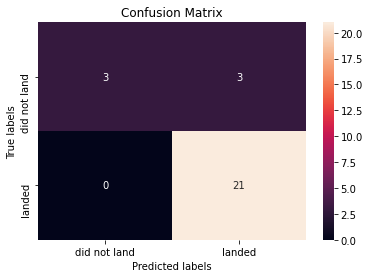

In [19]:
y_hat=logreg_cv.predict(x_test)
plot_confusion_matrix(y_test,y_hat)

Predict the probability. Use the loss function LogLoss to get the error rate.

In [20]:
yhat_proba = logreg_cv.predict_proba(x_test)

lr_log_loss = (metrics.log_loss(y_test, yhat_proba))

In [21]:
print('Grid Score',logreg_cv.score(x_test, y_test))# Best Score: 0.88 train_split_random_state: 2
print('Log Loss', metrics.log_loss(y_test, yhat_proba))# Best Loss: 0.31 train_split_radom_state: 2

Grid Score 0.8888888888888888
Log Loss 0.3161343460615488


Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the major problem is false positives.


## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv - 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>. Additionally Let's the parameter <code>probability</code> to true.


In [22]:
parameters2 = {'kernel':('rbf','linear','poly','sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC(probability=True)

In [23]:
svm_cv = GridSearchCV(svm, parameters2, cv=10)
svm_cv.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=SVC(probability=True),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('rbf', 'linear', 'poly', 'sigmoid')})

In [24]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)
print("best estimator:", svm_cv.best_estimator_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8872727272727273
best estimator: SVC(gamma=0.03162277660168379, kernel='sigmoid', probability=True)


## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [25]:
svm_test_score = (svm_cv.score(x_test, y_test))

We can plot the confusion matrix


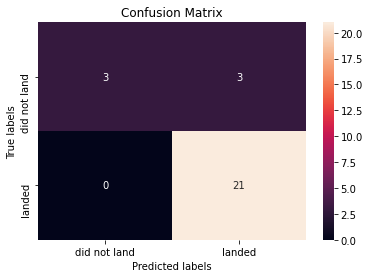

In [26]:
y_hat2 = svm_cv.predict(x_test)
plot_confusion_matrix(y_test,y_hat2)

Predict the probability. Use the loss function LogLoss to get the error rate.

In [27]:
yhat_proba2 = svm_cv.predict_proba(x_test)

svm_log_loss = (metrics.log_loss(y_test, yhat_proba2))

In [28]:
print('Grid Score',svm_cv.score(x_test, y_test))# Best Score: 0.88 train_split_random_state: 2
print('Log Loss', metrics.log_loss(y_test, yhat_proba2))# Best Loss: 0.30 train_split_radom_state: 2

Grid Score 0.8888888888888888
Log Loss 0.3058208903091429


## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [29]:
parameters3 = {'criterion': ['gini'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in np.arange(1,10)],
     'max_features': ['auto', 'sqrt', 'log2'],
     'min_samples_leaf': [1,2,4],
     'min_samples_split': [2,5,10]}

d_tree = DecisionTreeClassifier(random_state=6) #random_state: 6 with train_split_random_state: 2 is optimal for this model. #random_state: 6 with train_test_split_random_state: 2 is good overall.

In [30]:
tree_cv = GridSearchCV(d_tree, parameters3, cv=10)

tree_cv.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=6),
             param_grid={'criterion': ['gini'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [31]:
print("Tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("Accuracy :",tree_cv.best_score_)
print("best Estimator", tree_cv.best_estimator_)

Tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
Accuracy : 0.9045454545454547
best Estimator DecisionTreeClassifier(max_depth=4, max_features='auto', random_state=6,
                       splitter='random')


## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [32]:
tree_test_score = (tree_cv.score(x_test, y_test))

We can plot the confusion matrix


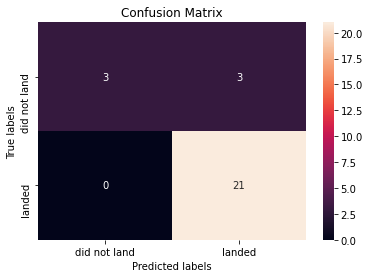

In [33]:
y_hat3 = tree_cv.predict(x_test)
plot_confusion_matrix(y_test,y_hat3)

Predict the probability. Use the loss function LogLoss to get the error rate.

In [34]:
yhat_proba3 = tree_cv.predict_proba(x_test)

tree_log_loss = (metrics.log_loss(y_test, yhat_proba3))

In [35]:
print('Grid Score',tree_cv.score(x_test, y_test))# Best Score: 0.88  train_split_random_state: 2 model_random_state: 6
print('Log Loss', metrics.log_loss(y_test, yhat_proba3))# Best Loss: 0.32 train_split_radom_state: 2 model_random_state: 6

Grid Score 0.8888888888888888
Log Loss 0.32957816538703616


## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [36]:
parameters4 = {'n_neighbors': [12], # k: 12 with train_test_split_random_state: 2 is optimal overall for this model  # k: 12 with train_test_split_random_state: 2 is good overall for this model 
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}
#11
KNN = KNeighborsClassifier()

In [37]:
knn_cv = GridSearchCV(KNN, parameters4, cv=10)

knn_cv.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [12], 'p': [1, 2]})

In [38]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)
print("best estimator:", knn_cv.best_estimator_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 12, 'p': 1}
accuracy : 0.8490909090909092
best estimator: KNeighborsClassifier(n_neighbors=12, p=1)


## TASK  11


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [39]:
knn_test_score = (knn_cv.score(x_test, y_test))

We can plot the confusion matrix


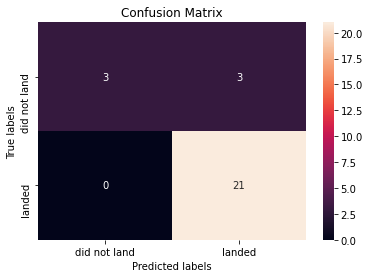

In [40]:
y_hat4 = knn_cv.predict(x_test)
plot_confusion_matrix(y_test,y_hat4)

Predict the probability. use the loss function LogLoss to get the error rate.

In [ ]:
yhat_proba4 = knn_cv.predict_proba(x_test)

knn_log_loss = (metrics.log_loss(y_test, yhat_proba4))

In [42]:
print('Grid Score',knn_cv.score(x_test, y_test))# Best Score: 0.88 k: 12 train_split_random_state: 2
print('Log Loss', metrics.log_loss(y_test, yhat_proba4))# Best Loss: 0.30 k: 12 train_split_radom_state: 2

Grid Score 0.8888888888888888
Log Loss 0.3006773249472405


## TASK  12


Find the method performs best:


I chose two compare different aproaches to find the best classification model: 

1st - I built a 'cross_val_function' using 'cross_val_score' from sklearn to retrieve the mean accuracy score and the std without any tuned hyperparemeters. Once done buiding the function, I test it on full dataset, on train set, test set. I printed the results as a dataframe.

2nd - I retrivied the actual score for the test set, and log loss for all four models with their respectives hyperparameters selected.

In [43]:
def cross_val_function(x, y, n_split):
    
    global df
    
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.model_selection import KFold, cross_val_score
    
    
    models = []
    models.append(('LR', LogisticRegression(C=0.1)))
    models.append(('SVM', SVC(gamma=0.03162277660168379, kernel='sigmoid', probability=True)))
    models.append(('TREE', DecisionTreeClassifier(max_depth=4, max_features='auto', random_state=6, splitter='random')))
    models.append(('KNN', KNeighborsClassifier(n_neighbors=12, p=1)))
    

    main_list = []
    
    for name, model in models:
        
        sub_list = []
       
        kfold = KFold(n_splits=int(n_split))
        cv_results = cross_val_score(model, x, y, cv=kfold, scoring='accuracy')
        sub_list.append(name)
        sub_list.append(cv_results.mean().round(decimals=2))
        sub_list.append(cv_results.std().round(decimals=2))
        
        main_list.append(sub_list)
        
     
    df = pd.DataFrame(main_list)
    
    df.columns = ['model', 'cv_score', 'cv_std']
    
    return(df)

Call the cross_val_function to view the accuracy scores and standard deviation of the scores for each model.  

In [44]:
cross_val_function(x_train,y_train,10)

,model,cv_score,cv_std
0,LR,0.86,0.11
1,SVM,0.88,0.09
2,TREE,0.90,0.09
3,KNN,0.86,0.10


The following lines of code are the actual results of the GridSearchCV score and Log Loss for the probability prediction:

In [45]:
lr_list = ['LR']
svm_list = ['SVM']
tree_list = ['TREE']
knn_list = ['KNN']
metod_list = []

lr_list.append(lr_test_score)
lr_list.append(lr_log_loss)

svm_list.append(svm_test_score)
svm_list.append(svm_log_loss)

tree_list.append(tree_test_score)
tree_list.append(tree_log_loss)

knn_list.append(knn_test_score)
knn_list.append(knn_log_loss)

metod_list.append(lr_list)
metod_list.append(svm_list)
metod_list.append(tree_list)
metod_list.append(knn_list)

View the GridSearch Score and the LogLoss rate for each model.

In [46]:
metod_df = pd.DataFrame(metod_list).round(decimals=2)
metod_df.columns = ['Model', 'test_score', 'log_loss']
metod_df

,Model,test_score,log_loss
0,LR,0.89,0.32
1,SVM,0.89,0.31
2,TREE,0.89,0.33
3,KNN,0.89,0.30


Plot the GridSearchCV and LogLoss results using matplotlib.

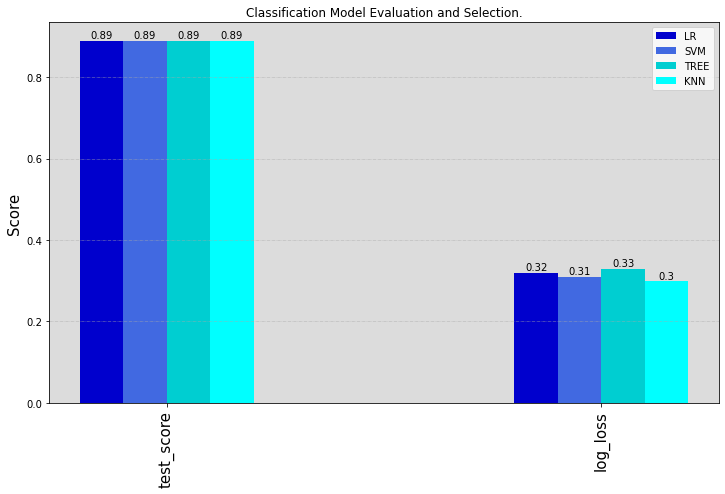

In [164]:
labels =  metod_df.drop(['Model'], axis=1).columns.tolist()
lr_bar = metod_df.iloc[0,1:].tolist()
svm_bar = metod_df.iloc[1,1:].tolist()
tree_bar = metod_df.iloc[2,1:].tolist()
knn_bar = metod_df.iloc[3,1:].tolist()

label_loc = np.arange(len(labels))
width = .10

xtick_loc = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(12,7))
lr_label = ax.bar(label_loc - 2*width +.05, lr_bar, width, label='LR', color='mediumblue')
svm_label = ax.bar(label_loc - width +.05, svm_bar, width, label='SVM', color='royalblue')
tree_label = ax.bar(label_loc +.05, tree_bar, width, label='TREE', color='darkturquoise')
knn_label = ax.bar(label_loc + width + .05, knn_bar, width, label='KNN', color= 'cyan')


ax.set_xticks(xtick_loc)
ax.set_xticklabels(labels, rotation=90, fontsize=15)
ax.set_title('Classification Model Evaluation and Selection.')
ax.grid(b=True, color='darkgray', linestyle='-.', linewidth=.5, alpha=.8, axis='y')
ax.set_ylabel('Score', fontsize=15)
ax.set_facecolor('gainsboro')
ax.legend()

list1 = []

for i, v in metod_df.iterrows():
    list1.append(v[1])
    list1.append(v[2])
    
rects = ax.patches

annot = [list1[index] for index in range(len(list1))]

for rects, annot in zip(rects, annot):
    height = rects.get_height()
    ax.text(rects.get_x() + rects.get_width() / 2, height, annot, ha='center', va='bottom')

plt.show()

### Conclusion: 

- Overall, all models do equaly well if train_test_split random_state is set to number '2'. Nevertheless, they can individually be optimize by simultaneously changing the train_test_split and models, random_state, k_numbers, and parameters when applicable.

## Authors


<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2021-01-01">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By    | Change Description      |
| ----------------- | ------- | ------------- | ----------------------- |
| 2021-08-31        | 1.1     | Lakshmi Holla | Modified markdown       |
| 2020-09-20        | 1.0     | Joseph        | Modified Multiple Areas |


Copyright © 2020 IBM Corporation. All rights reserved.
